In [398]:
import numpy as np
import matplotlib.pyplot as plt

def game(strategies, b):
    
    global bias 
    bias = b
    global prev_dice
    prev_dice = np.random.randint(1,7)
    board = np.zeros((4,4), dtype = int) - 1
    win = 0
    
    turns_played = 0
    total_eats = 0
    
    team_eats = [0,0,0,0]
    
    while win != 1:
        for i in range(0,4):
            turns_played += 1
            prev_eats = total_eats 
            board, total_eats = play(i, board, strategies[i,:], total_eats)
            team_eats[i] += total_eats - prev_eats
            #print(total_eats)
            #print(board)
            if sum(board[i,:]) == 118:
                win = 1
                return [i, turns_played, total_eats, team_eats]

In [394]:
def play(player, board, strategy, tot_eats):
    global bias
    global prev_dice
    if bias == 0:
        dice = np.random.randint(1, 7)
    else:
        dice = unfair_dice(prev_dice)
        
    prev_dice = dice
    
    transformBoard(player, board)
    moves = playableMoves(board, dice, player)
    
    if np.sum(moves) == 0:
        reverseBoard(player, board)
        return board, tot_eats
    
    util = utility(board, moves, dice, player)
    score = list(np.dot(strategy, util))
    move = score.index(max(score))
    
    result = newBoard(board, move, dice, player)
    tot_eats += result 
    reverseBoard(player, board)
    
    if dice == 6:
        board, tot_eats = play(player, board, strategy, tot_eats)
    
    return board, tot_eats

In [401]:
def newBoard(board, move, dice, player):
    eat_flag = 0
    if board[player, move] == -1:
        board[player, move] = 0
    else:
        board[player, move] += dice

    for i in range(0,4):
        for j in range(0, 4):
            if i != player:
                if board[i,j] == board[player, move] and board[i,j] < 28: 
                    #print("Lors")
                    eat_flag = 1
                    board[i,j] = -1
    return eat_flag 

In [396]:
def reverseBoard(player, board):
    oldBoard = np.array(board)
    for i in range(0,3):
        board[(player + i + 1) % 4,:] = (board[(player + i + 1) % 4,:] - 7 * (i+1)) % 28  
   

    mask = (oldBoard == -1) | (oldBoard > 27)
    board[mask] = oldBoard[mask]
    #for i in range(0,4):
       #for j in range(0,4):
            #if(oldBoard[i,j] == -1 or oldBoard[i,j] > 27):
                #board[i,j] = oldBoard[i,j]

In [314]:
def transformBoard(player, board):
    oldBoard = np.array(board)
    for i in range(0,3):
        board[(player + i + 1) % 4,:] = (board[(player + i + 1) % 4,:] + 7 * (i+1)) % 28  
    for i in range(0,4):
        for j in range(0,4):
            if(oldBoard[i,j] == -1 or oldBoard[i,j] > 27):
                board[i,j] = oldBoard[i,j]

In [315]:
def playableMoves(board, dice, player):
    moves = np.array([0,0,0,0])
    for i in range(0, 4):
        if len(np.where(board[player,:] == board[player,i] + dice)[0]) == 0 and board[player, i] + dice < 32 and board[player, i] != -1:
            moves[i] = 1
        else:
            moves[i] = 0
        if dice == 6 and len(np.where(board[player,:] == 0)[0]) == 0 and board[player, i] == -1:
            moves[i] = 1
        
    return moves

In [316]:
def utility(board, moves, dice, player):
    utils = np.zeros((10,4), dtype = float)
    
    utils[0,:] = lead(board, moves, dice, player)
    utils[1,:] = new(board, moves, dice, player)
    utils[2,:] = eat(board, moves, dice, player)
    utils[3,:] = goal(board, moves, dice, player)
    utils[4,:] = last(board, moves, dice, player)
    utils[5,:] = eaters(board, moves, dice, player)
    utils[6,:] = eatables(board, moves, dice, player)
    return utils

In [317]:
def lead(board, moves, dice, player):
    
    max = -2
    max_i = -1
    for i in range(0, 4):
        if moves[i] == 1 and board[player, i] > max and board[player, i] < 28:
            max = board[player, i]
            max_i = i
    
    if max_i < 0:
        return moves
    else:
        result = np.array([0,0,0,0])   
        result[max_i] = 1
        return result

In [318]:
def new(board, moves, dice, player):
    
    max = -2
    max_i = -1
    for i in range(0, 4):
        if moves[i] == 1 and board[player, i] == -1:
            max = board[player, i]
            max_i = i
            break
    
    if max_i < 0:
        return moves
    else:
        result = np.array([0,0,0,0])   
        result[max_i] = 1
        return result

In [319]:
def eat(board, moves, dice, player):
    
    result = np.array([0,0,0,0])
    for m in range(0,4):
        if moves[m] == 1:
            for i in range(0, 4):
                for j in range(0, 4):
                    if (board[player, m] + dice == board[i,j] and board[i,j] < 28 and board[player, m] != -1) or (board[i,j] == 0 and board[player, m] == -1):
                        result[m] = 1
                
    if sum(result) == 0:
        return moves
    else:
        return result

In [320]:
def goal(board, moves, dice, player):
    
    result = np.array([0,0,0,0])
    
    for m in range(0,4):
        if moves[m] == 1 and dice + board[player, m] > 27:
            result[m] = 1
    
    if sum(result) == 0:
        return moves
    else:
        return result

In [321]:
def last(board, moves, dice, player):
    
    min = 32
    min_i = -1
    for i in range(0, 4):
        if moves[i] == 1 and board[player, i] < min and board[player, i] > -1:
            min = board[player, i]
            min_i = i
    
    if min_i < 0:
        return moves
    else:
        result = np.array([0,0,0,0])   
        result[min_i] = 1
        return result

In [322]:
def can_be_eaten(board, place, dice, player):
    if dice == 6 and board[player, place] == -1:
        location = 0
    else:
        location = board[player, place] + dice
    
    if location > 27:
        return 0
    
    eaters = 0
    
    abs_board = np.array(board)
    reverseBoard(player, abs_board)
    for i in range(0, 4):
        if i != player:
            for j in range(0,4):
                difference = location - board[i,j]
                if board[i,j] < 28 and board[i,j] != -1 and difference <= 6 and difference > 0 and abs_board[i,j] + difference < 28:  
                    eaters += 1
    
    return eaters

In [323]:
def eaters(board, moves, dice, player):
    result = np.array([0, 0, 0, 0])
    for m in range(0,4):
        if moves[m] == 1:
            result[m] = can_be_eaten(board, m, 0, player) - can_be_eaten(board, m, dice, player)
    
    if sum(result) == 0:
        return moves
    else:
        return result

In [324]:
def can_eat(board, place, dice, player):
    
    if dice == 6 and board[player, place] == -1:
        location = 0
    else:
        location = board[player, place] + dice
    
    if location > 27:
        return 0
    
    can_eat = 0
    
    for i in range(0, 4):
        if i != player:
            for j in range(0,4):
                difference = board[i,j] - location
                if board[i,j] < 28 and board[i,j] != -1 and difference <= 6 and difference > 0:  
                    can_eat += 1
    
    return can_eat

In [325]:
def eatables(board, moves, dice, player):
    result = np.array([0, 0, 0, 0])
    for m in range(0,4):
        if moves[m] == 1:
            result[m] = can_eat(board, m, dice, player) - can_eat(board, m, 0, player)
    
    if sum(result) == 0:
        return moves
    else:
        return result

In [326]:
#lead
#new
#eat
#goal
#last
karki_liikkuu = np.array([100, 20, 30, 50, 0, 20, 10, 0, 0, 0])
juna_liikkuu  = np.array([0, 120, 30, 0, 100, 50, 10, 0, 0, 0])
full_destruction = np.array([0, 400, 500, 0, 0, 0, 200, 0, 0, 0])
smart = np.array([70, 10, 100, 200, 50, 20, 30, 0, 0, 0])
optimal = np.array([7,14,40,31,42,6,38,10,2,9])


In [327]:
strategies = np.zeros((4,10))
strategies[0,:] = karki_liikkuu
strategies[1,:] = juna_liikkuu
strategies[2,:] = full_destruction
strategies[3,:] = optimal

In [328]:
def games(n, strategies):
    wins = []
    for i in range(0,n):
        #if i % 10 == 0:
            #print(i)
        wins.append(game(strategies))
    return wins

wins = []
lengths = []
eats = []
for i in range(0, 1000):
    if i % 100 == 1:
        print(i)
    event = game(strategies)
    wins.append(event[0])
    lengths.append(event[1])
    eats.append(event[2])
    

In [412]:
iters = 1000
wins = []
eats = []
turns = []
team_wise_eats = np.array([0,0,0,0])

for i in range(0, iters):
    if(i % 100 == 5):
        print(i)
    result = game(strategies, 0)
    wins.append(result[0])
    eats.append(result[2])
    turns.append(result[1])
    team_wise_eats = team_wise_eats + np.array(result[3])

5
105
205
305
405
505
605
705
805
905


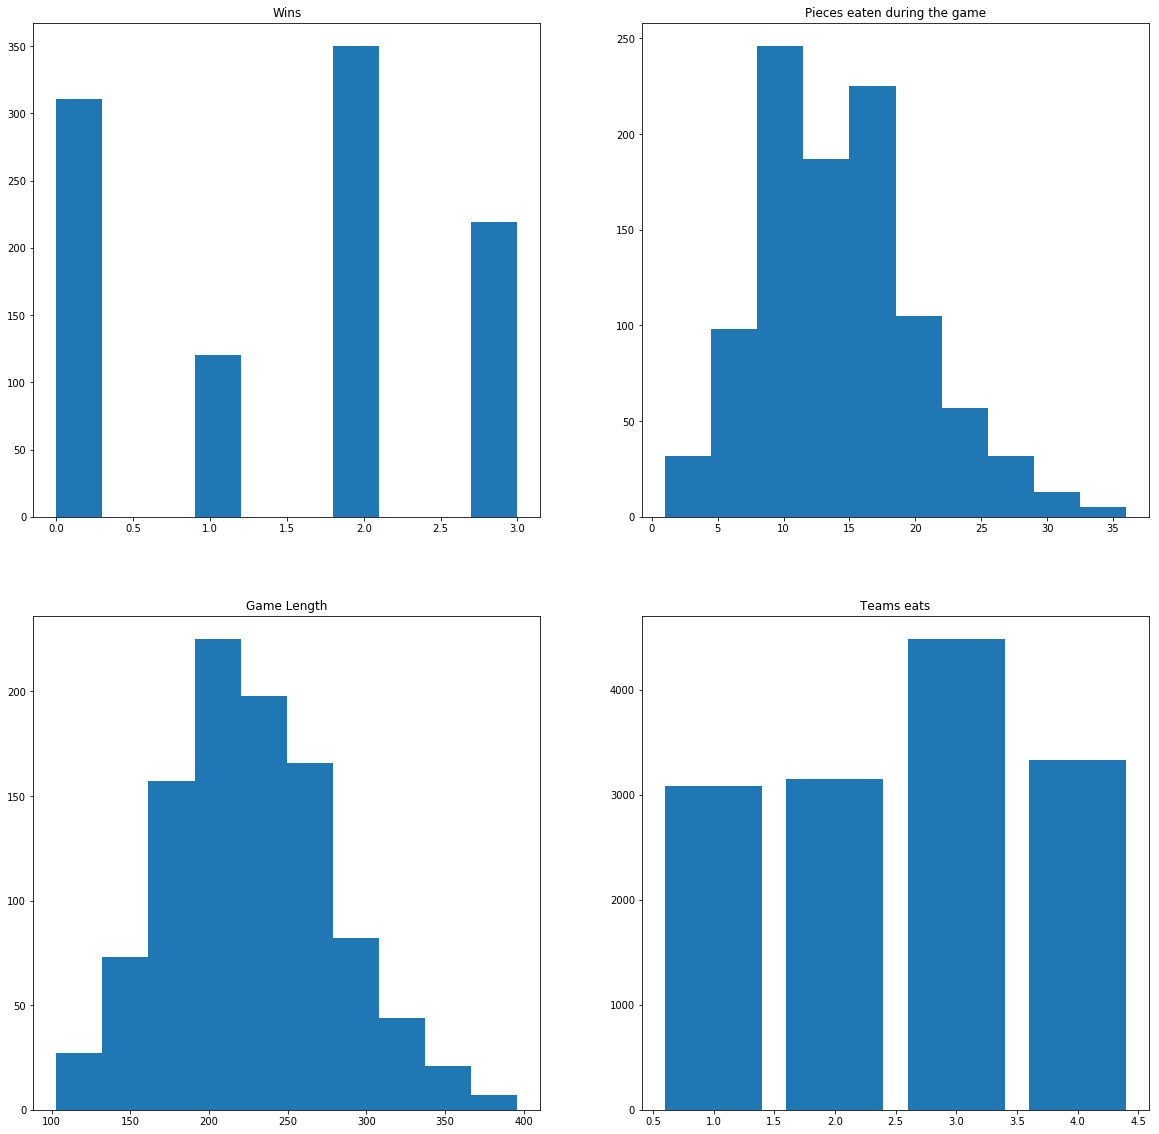

In [413]:
plt.figure(1, (20,20))
plt.subplot(221)
plt.hist(wins)
plt.title("Wins")
plt.subplot(222)
plt.hist(eats)
plt.title("Pieces eaten during the game")
plt.subplot(223)
plt.hist(turns)
plt.title("Game Length")
plt.subplot(224)
plt.bar([1,2,3,4], team_wise_eats)
plt.title("Teams eats")


In [345]:
game(strategies)

0
0
0
0
0
0
0
0
0
0
0
Result: 0
0
Result: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

TypeError: 'int' object is not iterable

In [363]:
def unfair_dice(previous_dice):
    r = np.random.uniform(0,1)
    new_dice = 0
    
    if previous_dice == 1:
        w1 = [1/13, 3/13, 5/13, 7/13, 9/13, 13/13]
        
        for i in range(6):
            if r < w1[i]:
                new_dice = i + 1
                break
                
    elif previous_dice == 2:
        w2 = [2/13, 3/13, 5/13, 7/13, 11/13, 13/13]
            
        for i in range(6):
            if r < w2[i]:
                new_dice = i + 1
                break
                
    elif previous_dice == 3:
        w3 = [2/13, 4/13, 5/13, 9/13, 11/13, 13/13]
        
        for i in range(6):
            if r < w3[i]:
                new_dice = i + 1
                break
                
    elif previous_dice == 4:
        w4 = [2/13, 4/13, 8/13, 9/13, 11/13, 13/13]
        
        for i in range(6):
            if r < w4[i]:
                new_dice = i + 1
                break
                
    elif previous_dice == 5:
        w5 = [2/13, 6/13, 8/13, 10/13, 11/13, 13/13]
        
        for i in range(6):
            if r < w5[i]:
                new_dice = i + 1
                break
    else:
        w6 = [4/13, 6/13, 8/13, 10/13, 12/13, 13/13]
        
        for i in range(6):
            if r < w6[i]:
                new_dice = i + 1
                break
                
    return new_dice

In [168]:
%prun wins = run_game(500, strategies)

         6516750 function calls (6494920 primitive calls) in 39.071 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   415386    7.900    0.000    8.224    0.000 <ipython-input-166-1b6dc8e7ca81>:1(reverseBoard)
   301360    4.577    0.000   10.224    0.000 <ipython-input-157-0a72ffab61f9>:1(can_be_eaten)
   301360    4.004    0.000    4.004    0.000 <ipython-input-159-04afb00925c3>:1(can_eat)
   133973    3.847    0.000    3.980    0.000 <ipython-input-149-02b2f3b97c4f>:1(transformBoard)
   133973    3.417    0.000    4.245    0.000 <ipython-input-150-a4abb519f9cb>:1(playableMoves)
    90964    2.934    0.000    3.372    0.000 <ipython-input-154-0f708fc5e2be>:1(eat)
  1516177    2.247    0.000    2.247    0.000 {built-in method numpy.core.multiarray.array}
   475999    1.225    0.000    1.225    0.000 {built-in method builtins.sum}
    90964    1.185    0.000   23.061    0.000 <ipython-input-151-360d3de43b87>:1(utility)
133